## Packages and definition of parameters

In [2]:
# --- packages --- #
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import os, sys, glob
import matplotlib.colors as colors
from scipy.stats import binned_statistic_2d
pd.set_option("display.max_columns", None)

from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

from ctapipe.instrument import SubarrayDescription
from magicctapipe.utils import calculate_impact


# --- path to all scripts --- #
sys.path.insert(0, '/fefs/aswg/workspace/juan.jimenez/stereo_analysis/scripts')
import auxiliar as aux
import geometry as geom
# graphic parameters
aux.params()

# # -- image fitting limits [m] for the maps --- #
# ylim  = (-110, 110)
# xlim  = (-90,   90)

# --- paths --- #
dir_mask = '/fefs/aswg/LST1MAGIC/mc/DL2/ST0316A/NSB1.5/GammaTest/v01.2/dec_2276/*.h5'
event_coinc_dir   = '/fefs/aswg/workspace/juan.jimenez/data/dl1/joint_runs_magic_lst'
dir_stereo_reco   = '/fefs/aswg/workspace/juan.jimenez/data/datasets/'
name_stereo_3T    = 'stereo_data_3T'
name_stereo_total = 'stereo_data_total'

filenames = glob.glob(dir_mask)
filenames.sort()
print(f'{len(filenames)} MC files found')
for i,f in zip(range(len(filenames)),filenames):
    index1, index2 = f.find('/dl2_'), f.find(f'_LST-1_MAGIC_')
    f = f.replace('_', ' ')
    
# --- selecting file --- #
index_file = 21
print(f'\nThe file selected is:\n{filenames[index_file]}')

kw_txt = dict(ha='center', va='center')

67 MC files found

The file selected is:
/fefs/aswg/LST1MAGIC/mc/DL2/ST0316A/NSB1.5/GammaTest/v01.2/dec_2276/dl2_gamma_zd_43.197deg_az_262.71deg_LST-1_MAGIC_run106_to_50006.h5


In [3]:
###########################################
# --- telescopes positions extraction --- #
###########################################

tel_positions = SubarrayDescription.from_hdf(filenames[index_file]).positions

coord_t1, coord_t2, coord_t3 = [tel_positions[tel_index].value for tel_index in [1, 2, 3]]

xpos = np.array([tel_positions[i].value[0] for i in [1, 2, 3]])
ypos = np.array([tel_positions[i].value[1] for i in [1, 2, 3]])
zpos = np.array([tel_positions[i].value[2] for i in [1, 2, 3]])

# applying a 90 degree rotation to set the north in the y direction
xpos, ypos = ypos, xpos
xpos = xpos * (-1)

coord_t1 = [xpos[0], ypos[0], zpos[0]]
coord_t2 = [xpos[1], ypos[1], zpos[1]]
coord_t3 = [xpos[2], ypos[2], zpos[2]]

print(f'\nExtracting telescopes positions:')
print(f'LST-1   coords:  [{xpos[0]:.2f}, {ypos[0]:.2f}, {zpos[0]:.2f}] m')
print(f'MAGIC-1 coords:  [{xpos[1]:.2f}, {ypos[1]:.2f}, {zpos[1]:.2f}] m')
print(f'MAGIC-2 coords:  [{xpos[2]:.2f}, {ypos[2]:.2f}, {zpos[2]:.2f}] m')

###########################################

#####################################
# --- dataframes of MC analysis --- #
#####################################
print(f'\nReading .h5 file')
df   = pd.read_hdf(filenames[index_file], key='/events/parameters').query(f'combo_type == 3 & tel_id == 1')
dfT1 = pd.read_hdf(filenames[index_file], key='/events/parameters').query(f'combo_type == 3 & tel_id == 1')
dfT2 = pd.read_hdf(filenames[index_file], key='/events/parameters').query(f'combo_type == 3 & tel_id == 2')
dfT3 = pd.read_hdf(filenames[index_file], key='/events/parameters').query(f'combo_type == 3 & tel_id == 3')

# --- dropping non useful columns of the df --- #
del_cols = ['obs_id', 'event_id', 'tel_id', 'n_pixels', 'n_islands', 'magic_stereo', 'intensity', 'skewness',
            'kurtosis', 'x', 'y', 'r', 'length', 'length_uncertainty', 'width', 'width_uncertainty', 
            'intercept', 'deviation', 'slope', 'pixels_width_1', 'pixels_width_2', 'intensity_width_1',
            'intensity_width_2', 'multiplicity', 'combo_type', 'alt_uncert', 'az_uncert', 'true_disp', 
            'off_axis', 'reco_energy_var', 'reco_disp', 'reco_disp_var', 'disp_diff_sum', 'disp_diff_mean',
            'gammaness_var', 'impact', 'true_impact']

df   = df.drop(  del_cols,      axis=1)
dfT1 = dfT1.drop(del_cols[:-2], axis=1)
dfT2 = dfT2.drop(del_cols[:-2], axis=1)
dfT3 = dfT3.drop(del_cols[:-2], axis=1)
#####################################

display(df.head(5))


Extracting telescopes positions:
LST-1   coords:  [-77.13, -8.09, 0.78] m
MAGIC-1 coords:  [62.55, 39.30, -0.97] m
MAGIC-2 coords:  [14.57, -31.21, 0.20] m

Reading .h5 file


,pointing_alt,pointing_az,true_energy,true_alt,true_az,true_core_x,true_core_y,phi,psi,alt,az,core_x,core_y,h_max,reco_energy,reco_alt,reco_az,gammaness
0,0.816866,4.585189,4.300905,46.860367,262.131350,260.049988,-260.648987,27.937922,41.565336,46.869066,262.186653,233.672078,-212.325619,13055.199717,3.994435,46.892635,262.198553,0.984167
15,0.816866,4.585189,0.772663,46.996783,263.222103,-47.475445,209.951050,147.388175,9.625923,47.050894,263.224032,-59.375693,312.252877,16511.286548,1.052071,46.992178,263.220066,0.995000
18,0.816866,4.585189,0.487729,46.940899,262.160637,76.053009,-65.910393,-9.437183,31.282737,47.027241,262.342332,42.981765,-38.172664,13367.592836,0.378793,46.874629,262.168721,1.000000
21,0.816866,4.585189,0.260877,46.871128,262.133945,-43.945744,-228.769104,-36.929314,-19.619529,46.946337,262.097877,-53.399153,-217.784568,11997.350392,0.255030,46.996718,262.023994,0.968333
30,0.816866,4.585189,0.185322,46.531777,262.281450,101.234695,-26.377642,137.328912,51.936531,46.617881,262.615210,19.182530,6.325845,15456.228585,0.212684,46.459737,262.252078,0.899167


In [4]:
# --- changing the coordinates --- #

############################################
# --------------- angles ----------------- #
############################################
# extracting pointing direction #
# changing from alt to zd
# changing to az to angle in spherical coordinates
point_zd       = 90 - np.rad2deg(df['pointing_alt'].to_numpy()[0])
point_eq_angle = - np.rad2deg(df['pointing_az'].to_numpy()[0]) + 90
point_az       =   np.rad2deg(df['pointing_az'].to_numpy()[0])

df['pointing_zd']       = point_zd 
df['pointing_eq_angle'] = point_eq_angle
df['pointing_az']       = point_az

point_dir = (point_zd, point_eq_angle)
print(f'The pointing direction is zd = {point_zd:.2f}deg and az = {point_az:.2f}deg')

# reconstructed directions
zd = 90 - df['reco_alt'].to_numpy()
eq_angle = - df['reco_az'].to_numpy() + 90
df['reco_zd'] = zd
df['reco_eq_angle'] = eq_angle

# true directions
true_zd = 90 - df['true_alt'].to_numpy()
true_eq_angle = - df['true_az'].to_numpy() + 90
df['true_zd'] = true_zd
df['true_eq_angle'] = true_eq_angle

############################################

############################################
# -------------- positions --------------- #
############################################

# reconstructed core positions
df['core_x'], df['core_y'] = df['core_y'], df['core_x']
df['core_x'] = df['core_x'].to_numpy() * (-1)

core_x = df['core_x'].to_numpy()
core_y = df['core_y'].to_numpy()
core_z = np.zeros(len(core_x))
df['core_z'] = core_z

# true cores positions
df['true_core_x'], df['true_core_y'] = df['true_core_y'], df['true_core_x']
df['true_core_x'] = df['true_core_x'].to_numpy() * (-1)

true_core_x = df['true_core_x'].to_numpy()
true_core_y = df['true_core_y'].to_numpy()
true_core_z = np.zeros(len(true_core_x))
df['true_core_z'] = true_core_z

# altitude of maximum intensity
h_max = df['h_max'].to_numpy()
############################################

############################################
# ----------- reference points ----------- #
############################################
# reference point for the plane of the telescopes
ref_lower = np.array([0, 0, 0])
# reference point in the mean(h_max) altitude
ref_upper = geom.z_projection(*ref_lower, *point_dir, np.mean(h_max))

print(f'\nRef point for lower plane is [{ref_lower[0]:.1f}, {ref_lower[1]:.1f}, {ref_lower[2]:.1f}]m')
print(f'Ref point for upper plane is [{ref_upper[0]:.1f}, {ref_upper[1]:.1f}, {ref_upper[2]:.1f}]m')
############################################

##################################
# --- telescopes projections --- #
##################################
print(f'\nCalculating the telescope projection in the different planes...')
positions_sets = [[xpos[i], ypos[i], zpos[i]] for i in range(len(xpos))]
t1_lower = geom.plane_projection(ref_lower, point_dir, *positions_sets[0], point_zd, point_eq_angle)
t1_upper = geom.plane_projection(ref_upper, point_dir, *positions_sets[0], point_zd, point_eq_angle)
t2_lower = geom.plane_projection(ref_lower, point_dir, *positions_sets[1], point_zd, point_eq_angle)
t2_upper = geom.plane_projection(ref_upper, point_dir, *positions_sets[1], point_zd, point_eq_angle)
t3_lower = geom.plane_projection(ref_lower, point_dir, *positions_sets[2], point_zd, point_eq_angle)
t3_upper = geom.plane_projection(ref_upper, point_dir, *positions_sets[2], point_zd, point_eq_angle)
xpos_lower, xpos_upper = [t1_lower[0], t2_lower[0], t3_lower[0]], [t1_upper[0], t2_upper[0], t3_upper[0]]
ypos_lower, ypos_upper = [t1_lower[1], t2_lower[1], t3_lower[1]], [t1_upper[1], t2_upper[1], t3_upper[1]]
zpos_lower, zpos_upper = [t1_lower[2], t2_lower[2], t3_lower[2]], [t1_upper[2], t2_upper[2], t3_upper[2]]
##################################

###################################################
# --- calculating plane projections of points --- #
###################################################
print('\nProjecting the points in the planes...')
cores_set      = [core_x, core_y, core_z]
true_cores_set = [true_core_x, true_core_y, true_core_z]
dirs_set       = [zd, eq_angle]
true_dirs_set  = [true_zd, true_eq_angle]

# calculating the projections
proj_set   = geom.plane_projection(ref_lower, point_dir, *cores_set, *point_dir)
lower_set  = geom.plane_projection(ref_lower, point_dir, *cores_set, *dirs_set)
upper_set  = geom.plane_projection(ref_upper, point_dir, *cores_set, *dirs_set)
shower_set = geom.z_projection(*cores_set, *dirs_set, h_max)
true_proj_set  = geom.plane_projection(ref_lower, point_dir, *true_cores_set, *point_dir)
true_lower_set = geom.plane_projection(ref_lower, point_dir, *true_cores_set, *true_dirs_set)
true_upper_set = geom.plane_projection(ref_upper, point_dir, *true_cores_set, *true_dirs_set)

# saving it into the total dataframe
df['proj_x'],   df['proj_y'],   df['proj_z']   = proj_set
df['lower_x'],  df['lower_y'],  df['lower_z']  = lower_set
df['upper_x'],  df['upper_y'],  df['upper_z']  = upper_set
df['shower_x'], df['shower_y'], df['shower_z'] = shower_set
df['true_proj_x'],  df['true_proj_y'],  df['true_proj_z']  = true_proj_set
df['true_lower_x'], df['true_lower_y'], df['true_lower_z'] = true_lower_set
df['true_upper_x'], df['true_upper_y'], df['true_upper_z'] = true_upper_set

# saving it to individual variables
proj_x,   proj_y,   proj_z   = proj_set
lower_x,  lower_y,  lower_z  = lower_set
upper_x,  upper_y,  upper_z  = upper_set
shower_x, shower_y, shower_z = shower_set
true_proj_x,  true_proj_y,  true_proj_z  = true_proj_set
true_lower_x, true_lower_y, true_lower_z = true_lower_set
true_upper_x, true_upper_y, true_upper_z = true_upper_set
###################################################

#########################################
# ------- calculating distances ------- #
#########################################
print('\nCalculating distances...')
df['dist_core']  = geom.dist3d(*cores_set, *true_cores_set)
df['dist_proj']  = geom.dist3d(*proj_set,  *true_proj_set)
df['dist_lower'] = geom.dist3d(*lower_set, *true_lower_set)
df['dist_upper'] = geom.dist3d(*upper_set, *true_upper_set)
#########################################

######################################################
# --- recalculating and adding impact parameters --- #
######################################################
print('\nCalculating impact parameters...')
for tel, dataframe, coord in zip(['1', '2', '3'], [dfT1, dfT2, dfT3], [coord_t1, coord_t2, coord_t3]):
    df[f'impact_{tel}']            = dataframe['impact'].to_numpy()
    df[f'true_impact_{tel}']       = dataframe['true_impact'].to_numpy()
    
    df[f'recal_impact_{tel}']      = geom.line_point_distance(*cores_set,      *dirs_set,      coord)
    df[f'recal_true_impact_{tel}'] = geom.line_point_distance(*true_cores_set, *true_dirs_set, coord)
    
    df[f'error_impact_A_{tel}'] = np.array(df[f'true_impact_{tel}']       - df[f'impact_{tel}'])  
    df[f'error_impact_B_{tel}'] = np.array(df[f'recal_true_impact_{tel}'] - df[f'recal_impact_{tel}'])
    df[f'error_impact_C_{tel}'] = np.array(df[f'recal_impact_{tel}']      - df[f'impact_{tel}'])    
    df[f'error_impact_D_{tel}'] = np.array(df[f'recal_true_impact_{tel}'] - df[f'true_impact_{tel}'])
######################################################

####################################
# --- calculating other errors --- #
####################################
df['error_zd'] = df['true_zd'] - df['reco_zd']
df['error_az'] = df['true_az'] - df['reco_az']
####################################

# deleting redundant variables
del cores_set,      proj_set,      lower_set,      upper_set,      dirs_set,     shower_set
del true_cores_set, true_proj_set, true_lower_set, true_upper_set, true_dirs_set
del positions_sets

display(df.head(5))

The pointing direction is zd = 43.20deg and az = 262.71deg

Ref point for lower plane is [0.0, 0.0, 0.0]m
Ref point for upper plane is [-12684.7, -1622.3, 13619.3]m

Calculating the telescope projection in the different planes...

Projecting the points in the planes...

Calculating distances...

Calculating impact parameters...


,pointing_alt,pointing_az,true_energy,true_alt,true_az,true_core_x,true_core_y,phi,psi,alt,az,core_x,core_y,h_max,reco_energy,reco_alt,reco_az,gammaness,pointing_zd,pointing_eq_angle,reco_zd,reco_eq_angle,true_zd,true_eq_angle,core_z,true_core_z,proj_x,proj_y,proj_z,lower_x,lower_y,lower_z,upper_x,upper_y,upper_z,shower_x,shower_y,shower_z,true_proj_x,true_proj_y,true_proj_z,true_lower_x,true_lower_y,true_lower_z,true_upper_x,true_upper_y,true_upper_z,dist_core,dist_proj,dist_lower,dist_upper,impact_1,true_impact_1,recal_impact_1,recal_true_impact_1,error_impact_A_1,error_impact_B_1,error_impact_C_1,error_impact_D_1,impact_2,true_impact_2,recal_impact_2,recal_true_impact_2,error_impact_A_2,error_impact_B_2,error_impact_C_2,error_impact_D_2,impact_3,true_impact_3,recal_impact_3,recal_true_impact_3,error_impact_A_3,error_impact_B_3,error_impact_C_3,error_impact_D_3,error_zd,error_az
0,0.816866,262.711975,4.300905,46.860367,262.131350,260.648987,260.049988,27.937922,41.565336,46.869066,262.186653,212.325619,233.672078,13055.199717,3.994435,46.892635,262.198553,0.984167,43.197002,-172.711975,43.107365,-172.198553,43.139633,-172.131350,0.0,0.0,100.663821,219.391592,119.888789,100.980003,218.416762,120.067158,-12547.846623,-1514.582302,13759.658256,-11894.559156,-1425.076247,13055.199717,125.154308,242.721502,145.477623,125.477911,241.368829,145.617897,-12528.971854,-1507.524481,13778.078492,55.053992,42.412936,42.187500,27.301554,306.972708,333.062685,307.061291,348.200819,26.089977,41.139528,0.088582,15.138134,214.709119,241.062078,214.751819,253.409794,26.352959,38.657975,0.042700,12.347715,289.968215,316.260775,290.024574,328.201757,26.292560,38.177183,0.056359,11.940982,0.032268,-0.067204
15,0.816866,262.711975,0.772663,46.996783,263.222103,-209.951050,-47.475445,147.388175,9.625923,47.050894,263.224032,-312.252877,-59.375693,16511.286548,1.052071,46.992178,263.220066,0.995000,43.197002,-172.711975,43.007822,-173.220066,43.003217,-173.222103,0.0,0.0,-164.799749,-40.517835,-158.317144,-165.154702,-41.887544,-158.810891,-12819.364549,-1546.316170,13502.992432,-15605.789162,-1877.587502,16511.286548,-110.361942,-34.738941,-106.926610,-110.609774,-35.668582,-107.268170,-12763.787980,-1539.518241,13555.564966,102.991649,75.085667,75.302568,76.803894,177.380814,122.887542,177.214479,103.085673,-54.493272,-74.128806,-0.166335,-19.801869,285.395150,231.346987,285.128751,211.723812,-54.048163,-73.404939,-0.266399,-19.623175,240.352465,185.181502,240.124247,164.913496,-55.170963,-75.210751,-0.228218,-20.268006,-0.004605,0.002037
18,0.816866,262.711975,0.487729,46.940899,262.160637,65.910393,76.053009,-9.437183,31.282737,47.027241,262.342332,38.172664,42.981765,13367.592836,0.378793,46.874629,262.168721,1.000000,43.197002,-172.711975,43.125371,-172.168721,43.059101,-172.160637,0.0,0.0,18.040433,40.407044,21.615528,18.092100,40.219901,21.641357,-12634.099282,-1699.952035,13657.244203,-12365.337822,-1662.986806,13367.592836,31.040880,71.593529,37.438620,31.173920,71.270390,37.524041,-12605.173809,-1668.538924,13687.926511,43.163512,37.309231,37.249517,52.582036,94.853677,111.563456,94.583926,128.389386,16.709779,33.805460,-0.269751,16.825930,18.028967,38.920471,18.000935,36.581141,20.891504,18.580207,-0.028032,-2.339329,74.433598,103.502906,74.368843,110.131158,29.069308,35.762315,-0.064755,6.628252,-0.066270,-0.008083
21,0.816866,262.711975,0.260877,46.871128,262.133945,228.769104,-43.945744,-36.929314,-19.619529,46.946337,262.097877,217.784568,-53.399153,11997.350392,0.255030,46.996718,262.023994,0.968333,43.197002,-172.711975,43.003282,-172.023994,43.128872,-172.133945,0.0,0.0,120.531587,-65.836888,104.418362,121.034315,-66.955200,104.753385,-12498.139525,-1835.075851,13767.778951,-10862.971263,-1605.966180,11997.350392,125.894754,-57.102398,110.453902,126.160380,-58.121924,110.579860,-12525.831924,-1806.091531,13745.439307,14.492308,11.894646,11.758023,45.891388,225.198388,211.225612,225.422881,230.417857,-13.972775,4.994977,0.224493,19


The plotting limits that will be used in the data:
xlims:[-15221.7,2536.9], ylims:[-11355.8,9733.6], zlims:[-45204.1,43581.9]

Masking the points within the limits...


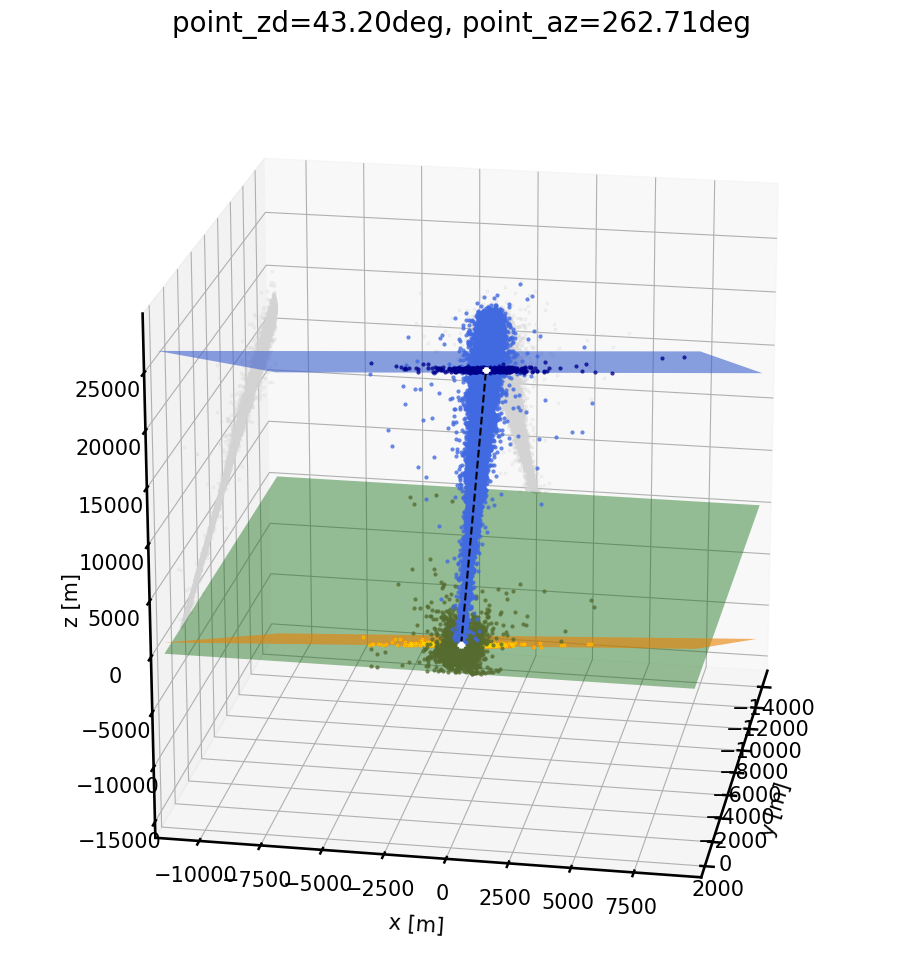

In [5]:
fig = plt.figure(figsize=(20,10))
fig.suptitle(f'point_zd={point_zd:.2f}deg, point_az={point_az:.2f}deg', fontsize=20)
ax  = fig.add_subplot(1, 1, 1, projection='3d') 

#####################################
# --- plot the reference points --- #
#####################################
ref_points = [[ref_lower[i], ref_upper[i]] for i in range(len(ref_lower))]
ax.plot(*ref_points,                        ls='--', c='k', marker='',  zorder=30, ms=4, lw=1.5, alpha=1)
ax.plot(xpos, ypos, zpos,                   ls='',   c='w', marker='+', zorder=30, ms=4, lw=2)
ax.plot(xpos_upper, ypos_upper, zpos_upper, ls='',   c='w', marker='+', zorder=30, ms=4, lw=2)
#####################################

###########################################
# --- finding the limits for the plot --- #
###########################################
# finding the limits for a given sigma
sigmas_plot = [.2, 6, 3.2]
lims = aux.lim_plot(ref_lower, ref_upper, factor=sigmas_plot)
xmin, xmax, ymin, ymax, zmin, zmax = lims

print(f'\nThe plotting limits that will be used in the data:')
print(f'xlims:[{xmin:.1f},{xmax:.1f}], ylims:[{ymin:.1f},{ymax:.1f}], zlims:[{zmin:.1f},{zmax:.1f}]')

# setting the limits in x and y
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
###########################################

#############################
# --- create the planes --- #
#############################
# x & y points for the planes
n_points_plane = 2
x_range = np.linspace(xmin, xmax, n_points_plane)
y_range = np.linspace(ymin, ymax, n_points_plane)
X_grid,  Y_grid  = np.meshgrid(x_range, y_range)

# reference planes
core_plane   = geom.z_plane(X_grid, Y_grid, ref_lower, [0, 0])
perp_plane   = geom.z_plane(X_grid, Y_grid, ref_lower, point_dir)
source_plane = geom.z_plane(X_grid, Y_grid, ref_upper, point_dir)

# --- plot the planes --- #
ax.plot_surface(X_grid, Y_grid, perp_plane,   alpha=0.6, color='darkorange', zorder=-100)
ax.plot_surface(X_grid, Y_grid, core_plane,   alpha=0.4, color='green',      zorder=-50)
ax.plot_surface(X_grid, Y_grid, source_plane, alpha=0.6, color='royalblue',  zorder=-60)
#############################

###############################
# --- plotting the points --- #
###############################
# computing the needed masks for our limits
print(f'\nMasking the points within the limits...')
core_mask   = aux.mask_3d(core_x,   core_y,   core_z,   lims)
proj_mask   = aux.mask_3d(proj_x,   proj_y,   proj_z,   lims)
upper_mask  = aux.mask_3d(upper_x,  upper_y,  upper_z,  lims)
lower_mask  = aux.mask_3d(lower_x,  lower_y,  lower_z,  lims)
shower_mask = aux.mask_3d(shower_x, shower_y, shower_z, lims)

cores   = core_x[core_mask],     core_y[core_mask],     core_z[core_mask]
lowers  = lower_x[lower_mask],   lower_y[lower_mask],   lower_z[lower_mask]
projs   = proj_x[proj_mask],     proj_y[proj_mask],     proj_z[proj_mask]
uppers  = upper_x[upper_mask],   upper_y[upper_mask],   upper_z[upper_mask]
showers = shower_x[shower_mask], shower_y[shower_mask], shower_z[shower_mask]

# plotting the points
kw = dict(alpha=.8, ms=1)
ax.plot(*cores,   'o', color='darkolivegreen', **kw, zorder=6, label='core positions')
ax.plot(*lowers,  'o', color='darkorange',     **kw, zorder=4,  label='$\perp$-plane trajectory ext.')
ax.plot(*projs,   '.', color='gold',           **kw, zorder=5, label='$\perp$-plane projection')
ax.plot(*uppers,  'o', color='darkblue',       **kw, zorder=10, label='h_max plane trajectory ext.')
ax.plot(*showers, 'o', color='royalblue',      **kw, zorder=9,  label='h_max positions')

# plotting the projection in the axes
kw = dict(color='lightgray', alpha=0.5, ls='', marker='.', zorder=-20, ms=1)
ax.plot(np.zeros(len(showers[0])) + xmin, showers[1], showers[2], **kw)
ax.plot(showers[0], np.zeros(len(showers[1])) + ymin, showers[2], **kw)
###############################

##################
# --- others --- #
##################
ax.set_xlabel('y [m]')
ax.set_ylabel('x [m]')
ax.zaxis.set_rotate_label(False)
ax.set_zlabel('z [m]', rotation=90)
ax.xaxis.labelpad = 5
ax.yaxis.labelpad = 10
ax.zaxis.labelpad = 17
ax.tick_params(axis='z', which='major', pad=10)
ax.tick_params(axis='x', rotation=0, which='major', pad=0)
fig.tight_layout()
ax.set_box_aspect([1,1,1])
##################

ax.view_init(20, 10)
plt.show()

# Checking sizes

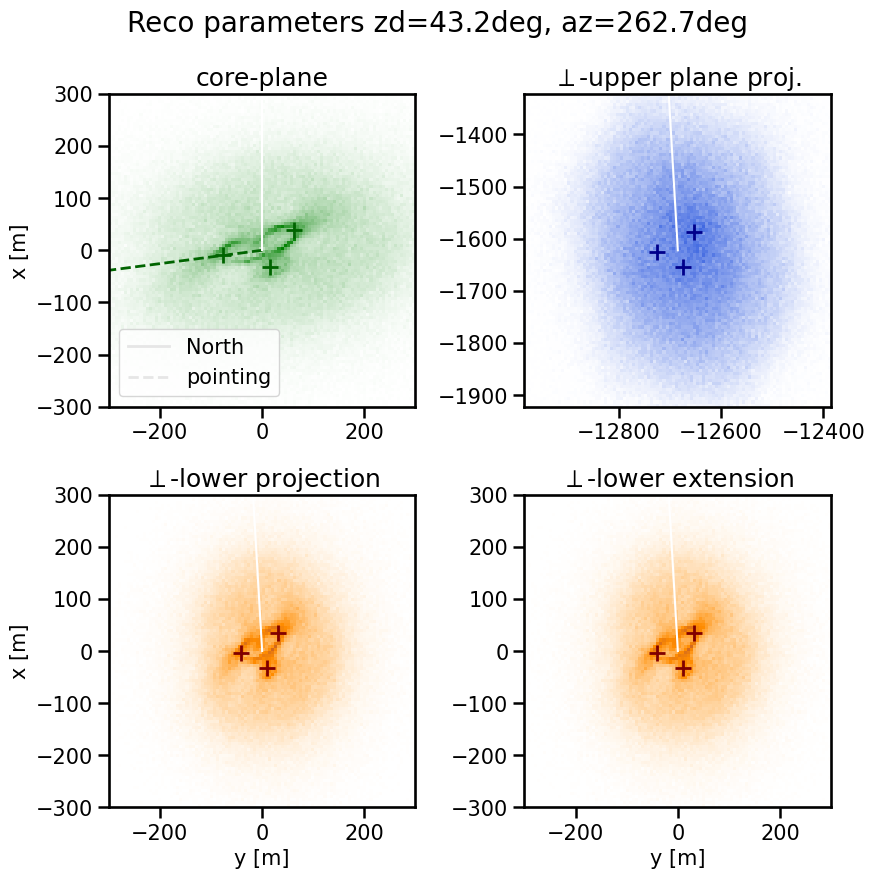

In [5]:
fig = plt.figure(figsize=(9, 9))
fig.suptitle(f'Reco parameters zd={point_zd:.1f}deg, az={point_az:.1f}deg', fontsize=20)
ax1 = fig.add_subplot(2, 2, 1) 
ax2 = fig.add_subplot(2, 2, 2) 
ax3 = fig.add_subplot(2, 2, 3) 
ax4 = fig.add_subplot(2, 2, 4) 

###################################
# --- plotting the histograms --- #
###################################
# creating colormaps
refscale = 300
ranges  = [[-refscale, refscale], [-refscale, refscale]]
ranges2 = [[ref_upper[0]-refscale, ref_upper[0]+refscale], [ref_upper[1]-refscale, ref_upper[1]+refscale]] 

cmapGreen = colors.LinearSegmentedColormap.from_list('',  ['w', 'g'])
cmapBlue = colors.LinearSegmentedColormap.from_list('',   ['w', 'royalblue'])
cmapOrange = colors.LinearSegmentedColormap.from_list('', ['w', 'darkorange','chocolate'])

# plotting histograms
Nbins = 100
ax1.hist2d(core_x,  core_y,  range=ranges,  bins=Nbins, cmap=cmapGreen)
ax2.hist2d(upper_x, upper_y, range=ranges2, bins=Nbins, cmap=cmapBlue)
ax3.hist2d(lower_x, lower_y, range=ranges,  bins=Nbins, cmap=cmapOrange)
ax4.hist2d(proj_x,  proj_y,  range=ranges,  bins=Nbins, cmap=cmapOrange)

###################################

#################################################
# --- plotting the telescopes in the planes --- #
#################################################
ax1.plot(xpos, ypos,             ls='', c='darkgreen', marker='+', zorder=30, ms=12, lw=2)
ax2.plot(xpos_upper, ypos_upper, ls='', c='darkblue',  marker='+', zorder=30, ms=12, lw=2)
ax3.plot(xpos_lower, ypos_lower, ls='', c='maroon',    marker='+', zorder=30, ms=12, lw=2)
ax4.plot(xpos_lower, ypos_lower, ls='', c='maroon',    marker='+', zorder=30, ms=12, lw=2)
#################################################

#######################################
# --- plotting the direction line --- #
#######################################
init_lower = ref_lower[:-1]
init_upper = ref_upper[:-1]
ax1.plot(*geom.line_in_direction(point_eq_angle, init_lower, ax1), ls='--', lw=2, c='darkgreen')
#######################################

############################
# --- projecting north --- #
############################
# calculating projection of north, 
north_point = [0, 1, 0]
proj_north = geom.plane_projection(ref_lower, point_dir, *north_point, *point_dir)

projected_point_dir = np.rad2deg(np.arctan2(proj_north[1], proj_north[0]))

dirs = [90, projected_point_dir, projected_point_dir, projected_point_dir]
for di, ax, init in zip(dirs, [ax1, ax2, ax3, ax4], [init_lower, init_upper, init_lower, init_lower]):
    ax.plot(*geom.line_in_direction(di      , init, ax), ls='-', lw=1.5, c='w')
#     ax.plot(*geom.line_in_direction(di - 180, init, ax), ls='-', lw=1.5, c='w')
############################

##################
# --- others --- #
##################
ax1.plot([], [], '-',  color='0.9', lw=2, label='North')
ax1.plot([], [], '--', color='0.9', lw=2, label='pointing')
ax1.legend()
titles = ['core-plane', '$\perp$-upper plane proj.', '$\perp$-lower projection', '$\perp$-lower extension']
for axe, t in zip([ax1, ax2, ax3, ax4], titles):
    axe.set_title(t)
    
for axis1, axis2 in zip([ax3, ax4], [ax1, ax3]):
    axis1.set_xlabel('y [m]')
    axis2.set_ylabel('x [m]')
##################

fig.tight_layout()
plt.show()

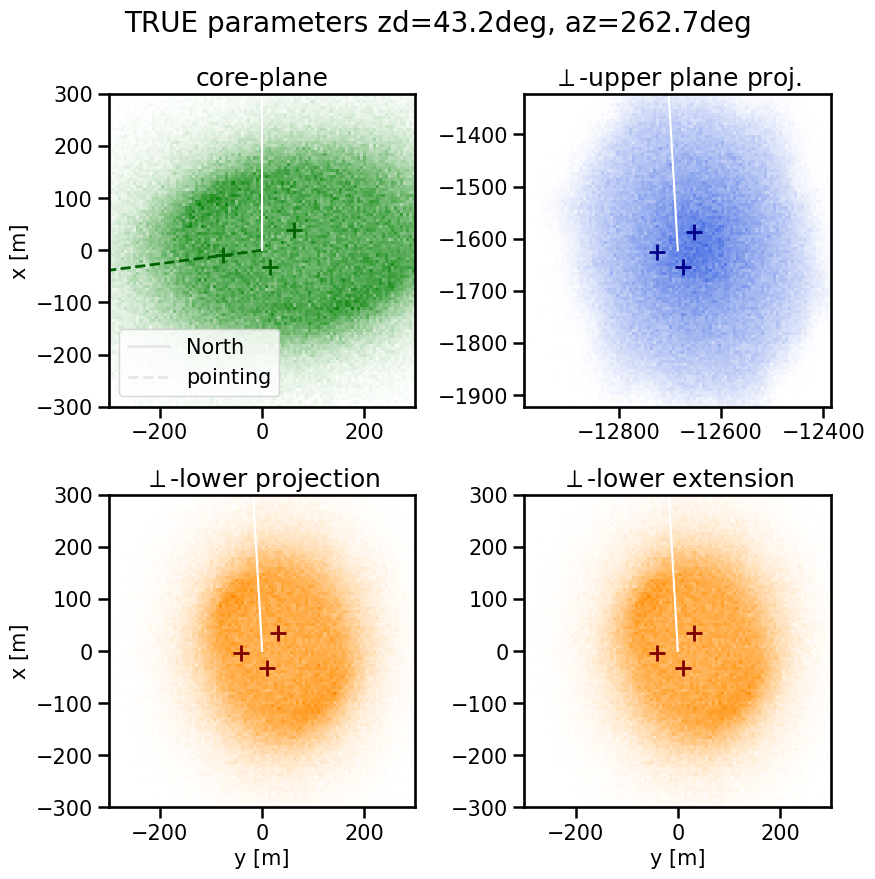

In [6]:
fig = plt.figure(figsize=(9, 9))
fig.suptitle(f'TRUE parameters zd={point_zd:.1f}deg, az={point_az:.1f}deg', fontsize=20)
ax1 = fig.add_subplot(2, 2, 1) 
ax2 = fig.add_subplot(2, 2, 2) 
ax3 = fig.add_subplot(2, 2, 3) 
ax4 = fig.add_subplot(2, 2, 4) 

###################################
# --- plotting the histograms --- #
###################################
# creating colormaps
refscale = 300
ranges  = [[-refscale, refscale], [-refscale, refscale]]
ranges2 = [[ref_upper[0]-refscale, ref_upper[0]+refscale], [ref_upper[1]-refscale, ref_upper[1]+refscale]] 

cmapGreen = colors.LinearSegmentedColormap.from_list('',  ['w', 'green'])
cmapBlue = colors.LinearSegmentedColormap.from_list('',   ['w', 'royalblue'])
cmapOrange = colors.LinearSegmentedColormap.from_list('', ['w', 'darkorange'])

# plotting histograms
Nbins = 100
ax1.hist2d(true_core_x,  true_core_y,  range=ranges,  bins=Nbins, cmap=cmapGreen)
ax2.hist2d(true_upper_x, true_upper_y, range=ranges2, bins=Nbins, cmap=cmapBlue)
ax3.hist2d(true_lower_x, true_lower_y, range=ranges,  bins=Nbins, cmap=cmapOrange)
ax4.hist2d(true_proj_x,  true_proj_y,  range=ranges,  bins=Nbins, cmap=cmapOrange)

###################################

#################################################
# --- plotting the telescopes in the planes --- #
#################################################
ax1.plot(xpos, ypos,             ls='', c='darkgreen', marker='+', zorder=30, ms=12, lw=2)
ax2.plot(xpos_upper, ypos_upper, ls='', c='darkblue',  marker='+', zorder=30, ms=12, lw=2)
ax3.plot(xpos_lower, ypos_lower, ls='', c='maroon',    marker='+', zorder=30, ms=12, lw=2)
ax4.plot(xpos_lower, ypos_lower, ls='', c='maroon',    marker='+', zorder=30, ms=12, lw=2)
#################################################

#######################################
# --- plotting the direction line --- #
#######################################
init_lower = ref_lower[:-1]
init_upper = ref_upper[:-1]
ax1.plot(*geom.line_in_direction(point_eq_angle, init_lower, ax1), ls='--', lw=2, c='darkgreen')
#######################################

############################
# --- projecting north --- #
############################
# calculating projection of north, 
north_point = [0, 1, 0]
proj_north = geom.plane_projection(ref_lower, point_dir, *north_point, *point_dir)

projected_point_dir = np.rad2deg(np.arctan2(proj_north[1], proj_north[0]))

dirs = [90, projected_point_dir, projected_point_dir, projected_point_dir]
for di, ax, init in zip(dirs, [ax1, ax2, ax3, ax4], [init_lower, init_upper, init_lower, init_lower]):
    ax.plot(*geom.line_in_direction(di      , init, ax), ls='-', lw=1.5, c='w')
#     ax.plot(*geom.line_in_direction(di - 180, init, ax), ls='-', lw=1.5, c='w')
############################

##################
# --- others --- #
##################
ax1.plot([], [], '-',  color='0.9', lw=2, label='North')
ax1.plot([], [], '--', color='0.9', lw=2, label='pointing')
ax1.legend()
titles = ['core-plane', '$\perp$-upper plane proj.', '$\perp$-lower projection', '$\perp$-lower extension']
for axe, t in zip([ax1, ax2, ax3, ax4], titles):
    axe.set_title(t)
    
for axis1, axis2 in zip([ax3, ax4], [ax1, ax3]):
    axis1.set_xlabel('y [m]')
    axis2.set_ylabel('x [m]')
##################

fig.tight_layout()
plt.show()

## Checking impact parameter recalculation

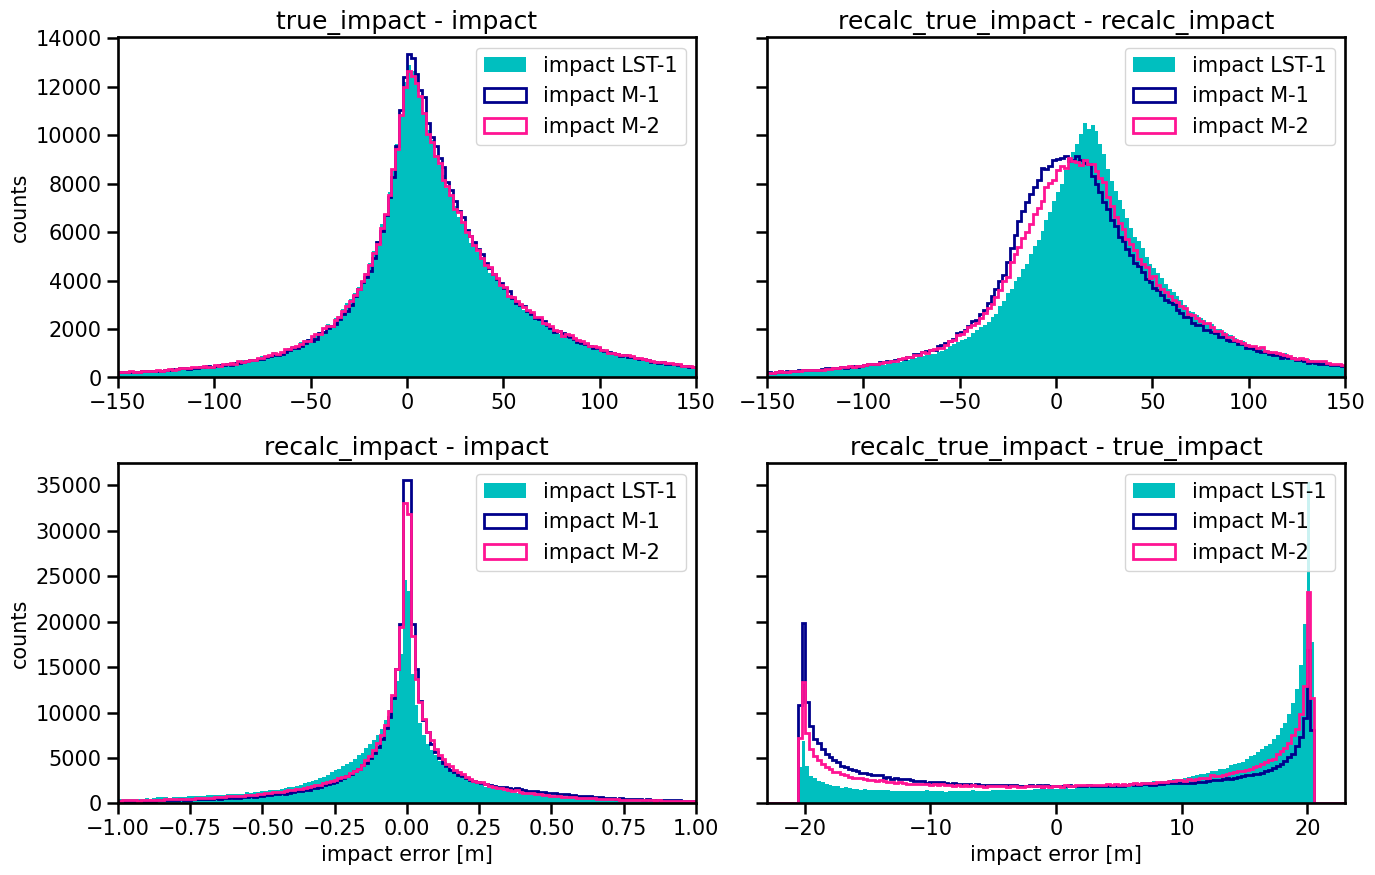

In [7]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14, 9), sharey='row')

range_1 = (-150, 150)
range_2 = (-1, 1)
range_3 = (-23, 23)

kws = [dict(histtype='stepfilled', color='c'), dict(histtype='step', color='darkblue'), 
       dict(histtype='step', color='deeppink')]
for tel, lab, kw in zip([1,2,3], ['impact LST-1', 'impact M-1', 'impact M-2'], kws):
    ax1.hist(df[f'error_impact_A_{tel}'], bins=150, range=range_1, **kw, label=lab, lw=2)
    
for tel, lab, kw in zip([1,2,3], ['impact LST-1', 'impact M-1', 'impact M-2'], kws):
    ax2.hist(df[f'error_impact_B_{tel}'], bins=150, range=range_1, **kw, label=lab, lw=2)
    
for tel, lab, kw in zip([1,2,3], ['impact LST-1', 'impact M-1', 'impact M-2'], kws):
    ax3.hist(df[f'error_impact_C_{tel}'], bins=150, range=range_2, **kw, label=lab, lw=2)
    
for tel, lab, kw in zip([1,2,3], ['impact LST-1', 'impact M-1', 'impact M-2'], kws):
    ax4.hist(df[f'error_impact_D_{tel}'], bins=150, range=range_3, **kw, label=lab, lw=2)
    

ax1.set_xlim(*range_1)
ax2.set_xlim(*range_1)
ax3.set_xlim(*range_2)
ax4.set_xlim(*range_3)

titles = ['true_impact - impact', 'recalc_true_impact - recalc_impact', 
          'recalc_impact - impact', 'recalc_true_impact - true_impact']
for ax, loc, title in zip([ax1, ax2, ax3, ax4], [1, 1, 1, 1], titles):
    ax.legend(loc=loc)
    ax.set_title(title)
    
ax3.set_xlabel('impact error [m]')
ax4.set_xlabel('impact error [m]')
ax1.set_ylabel('counts')
ax3.set_ylabel('counts')
fig.tight_layout()
plt.show()

In [8]:
# --- binning the data in positions --- #
ylim  = (-110, 110)
xlim  = (-90,   90)

Nbins = 80
bins_x = np.linspace(*xlim, Nbins)
bins_y = np.linspace(*ylim, Nbins)
bins   = (bins_x, bins_y)
bins_x_center = (bins_x[:-1] + bins_x[1:]) / 2
bins_y_center = (bins_y[:-1] + bins_y[1:]) / 2


tcore_set  = [df['true_core_x'], df['true_core_y']]
core_set   = [df['core_x'], df['core_y']]

binned_i   = [binned_statistic_2d(*core_set,  df[f'impact_{t}'],            bins=bins)[0].T for t in [1,2,3]]
binned_ti  = [binned_statistic_2d(*tcore_set, df[f'true_impact_{t}'],       bins=bins)[0].T for t in [1,2,3]]
binned_ri  = [binned_statistic_2d(*core_set,  df[f'recal_impact_{t}'],      bins=bins)[0].T for t in [1,2,3]]
binned_rti = [binned_statistic_2d(*tcore_set, df[f'recal_true_impact_{t}'], bins=bins)[0].T for t in [1,2,3]]

binned_A = [binned_statistic_2d(*core_set,  df[f'error_impact_A_{t}'], bins=bins)[0].T for t in [1,2,3]]


binned_B = [binned_statistic_2d(*tcore_set, df[f'error_impact_B_{t}'], bins=bins)[0].T for t in [1,2,3]]
binned_C = [binned_statistic_2d(*core_set,  df[f'error_impact_C_{t}'], bins=bins)[0].T for t in [1,2,3]]
binned_D = [binned_statistic_2d(*tcore_set, df[f'error_impact_D_{t}'], bins=bins)[0].T for t in [1,2,3]]

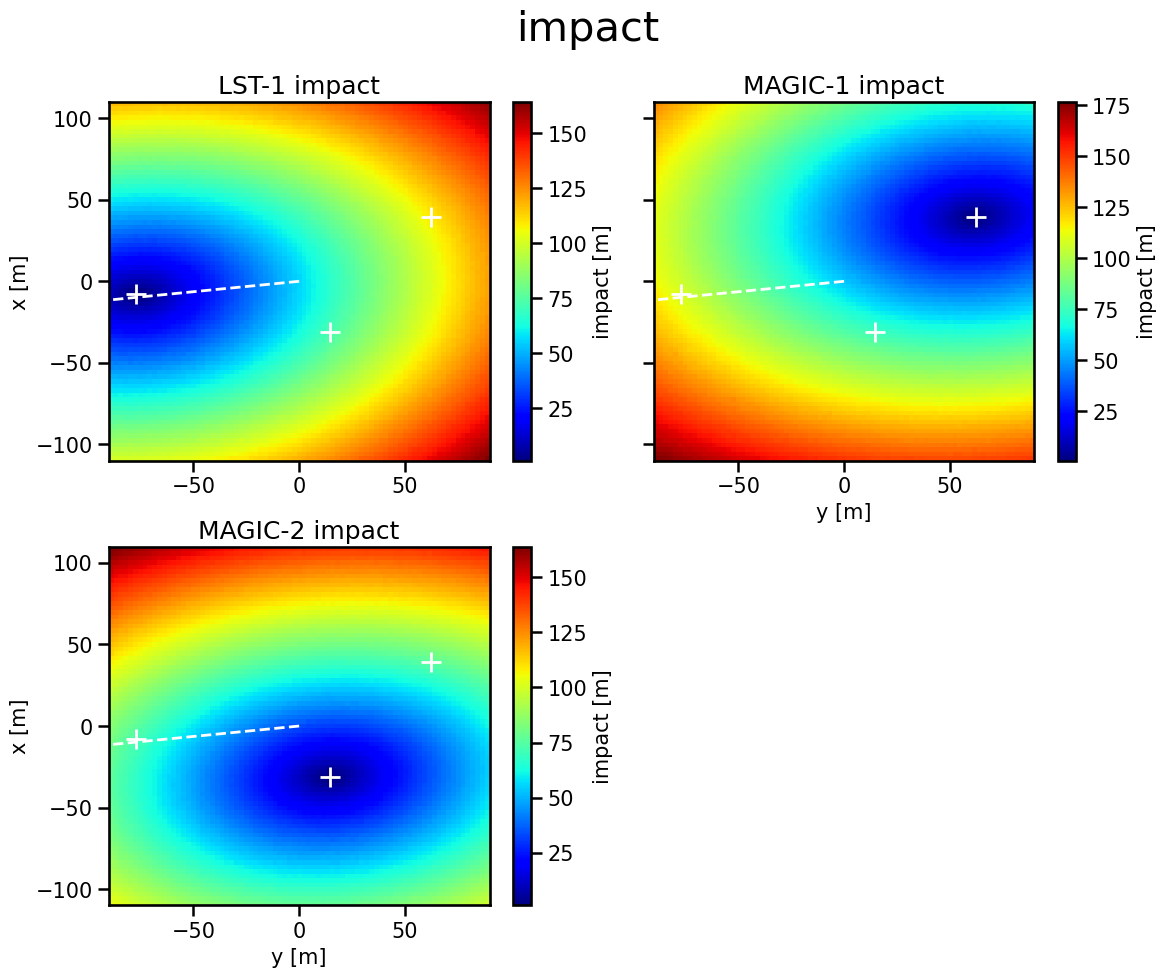

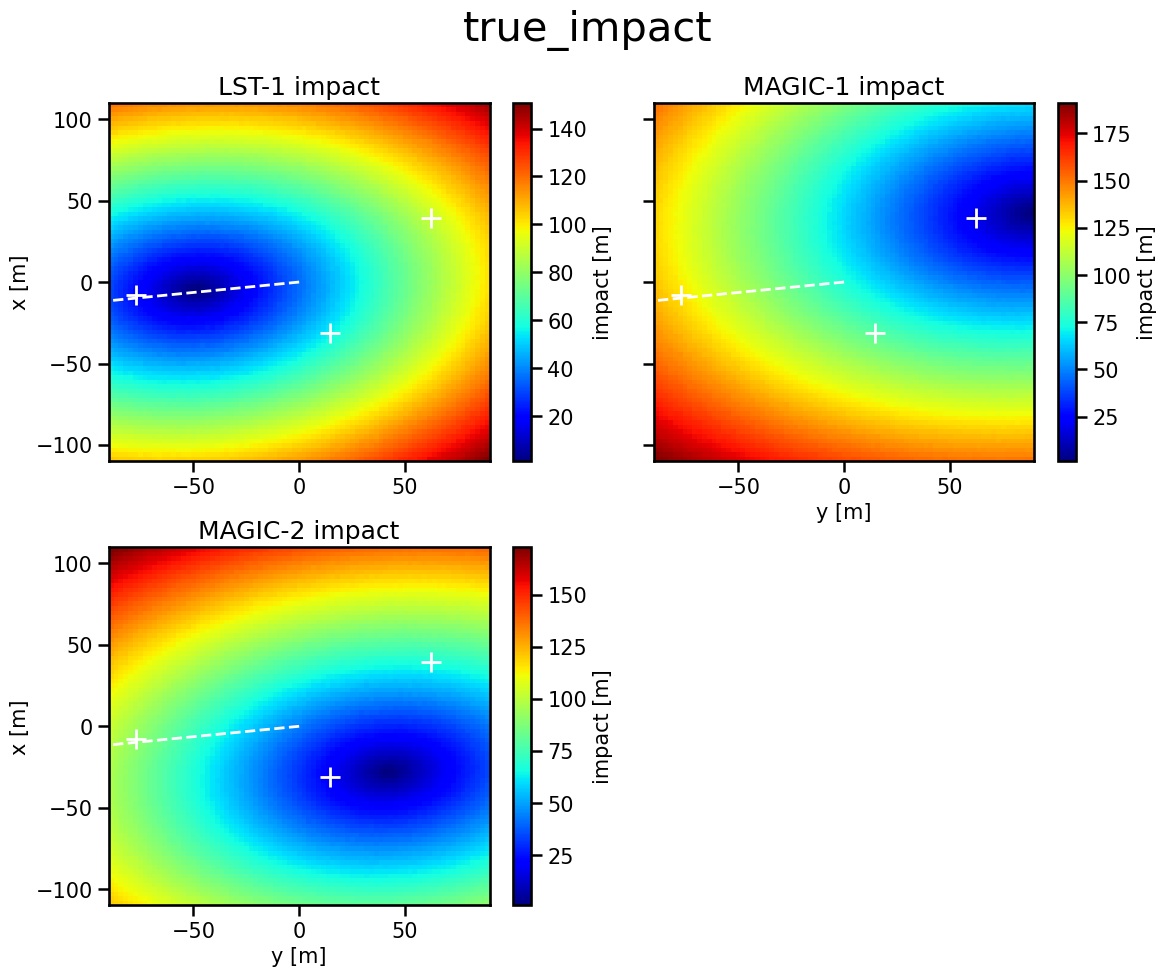

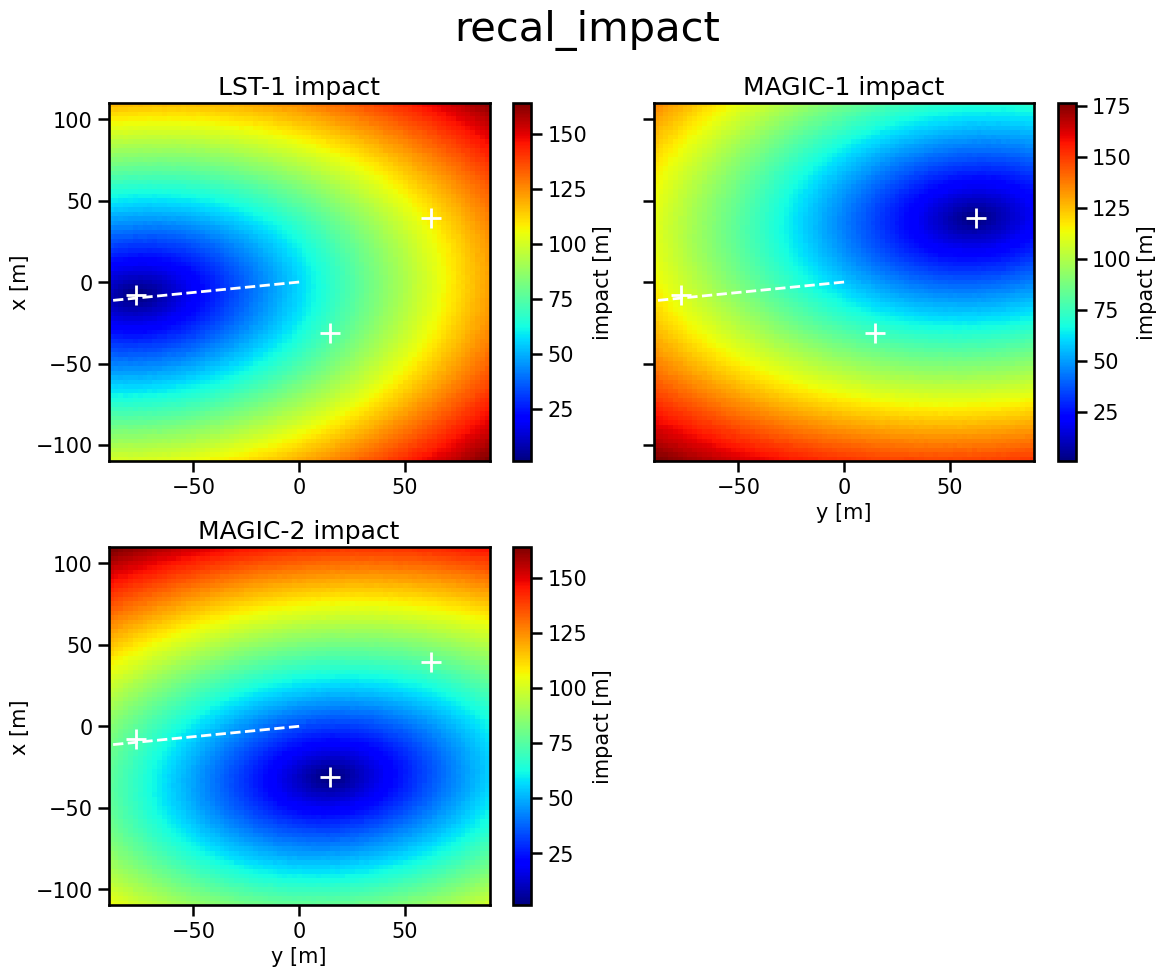

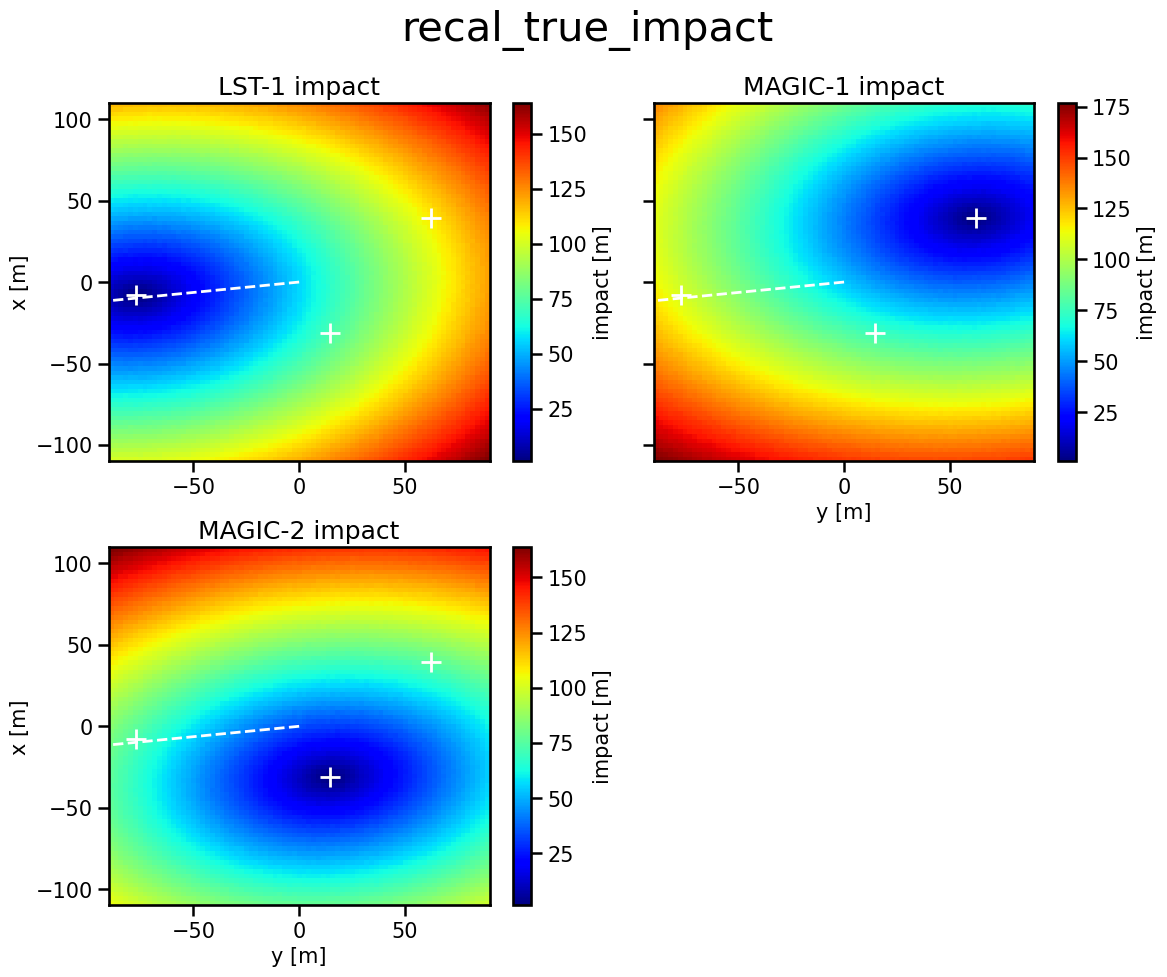

In [9]:
titles = ['impact', 'true_impact', 'recal_impact', 'recal_true_impact']

for title, data in zip(titles, [binned_i, binned_ti, binned_ri, binned_rti]):

    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 10), sharey=True)
    fig.suptitle(title, fontsize=30)

    # plot the binned data
    for ax, i in zip([ax1, ax2, ax3], [0,1,2]):
    
        cmesh = ax.pcolormesh(bins_x_center, bins_y_center, data[i], cmap='jet')
        fig.colorbar(cmesh, ax=ax, label='impact [m]')

    #######################################
    # --- plotting the direction line --- #
    #######################################
    init_lower = ref_lower[:-1]
    init_upper = ref_upper[:-1]
    
    for ax in [ax1, ax2, ax3]:
        ax.plot(*geom.line_in_direction(point_eq_angle, init_lower, ax), ls='--', lw=2, c='w')
    #######################################

    for ax, t in zip([ax1, ax2, ax3], ['LST-1 impact', 'MAGIC-1 impact', 'MAGIC-2 impact']):
        ax.set_title(t)
        ax.set_xlim(*xlim)
        ax.set_ylim(*ylim)
        ax.plot(xpos, ypos, ls='', c='w', marker='+', ms=15, lw=20)

    ax3.set_xlabel('y [m]')
    ax2.set_xlabel('y [m]')
    ax1.set_ylabel('x [m]')
    ax3.set_ylabel('x [m]')

    fig.delaxes(ax4)
    fig.tight_layout()
    plt.show()

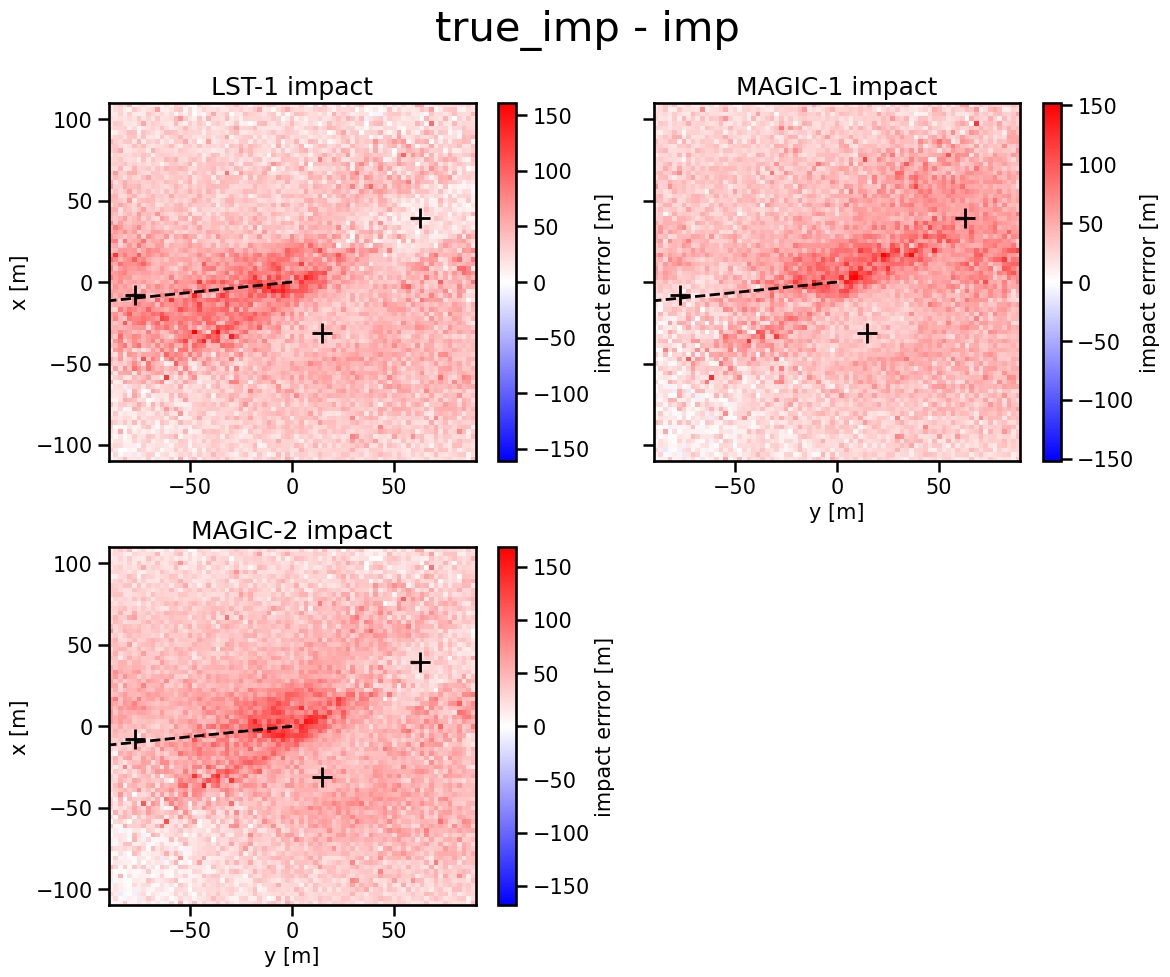

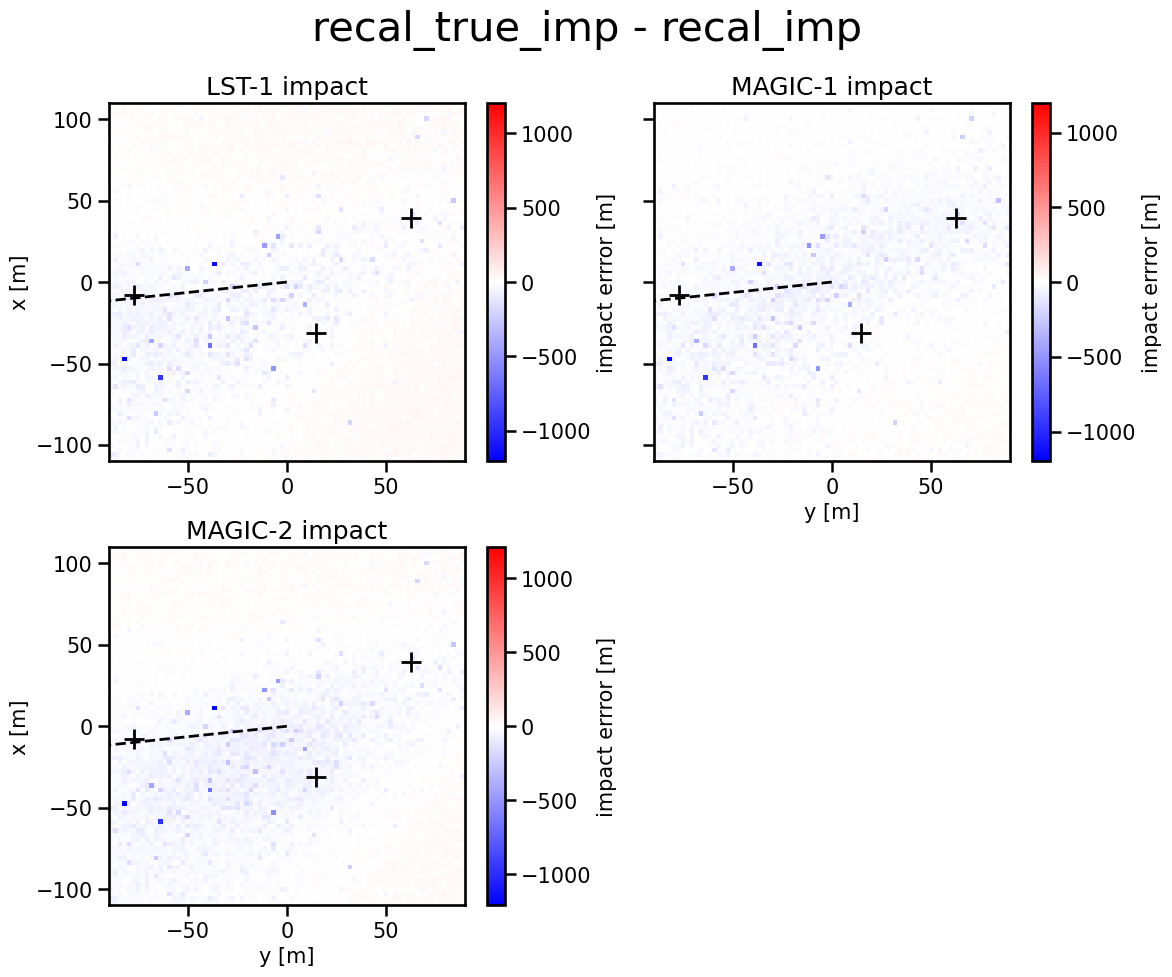

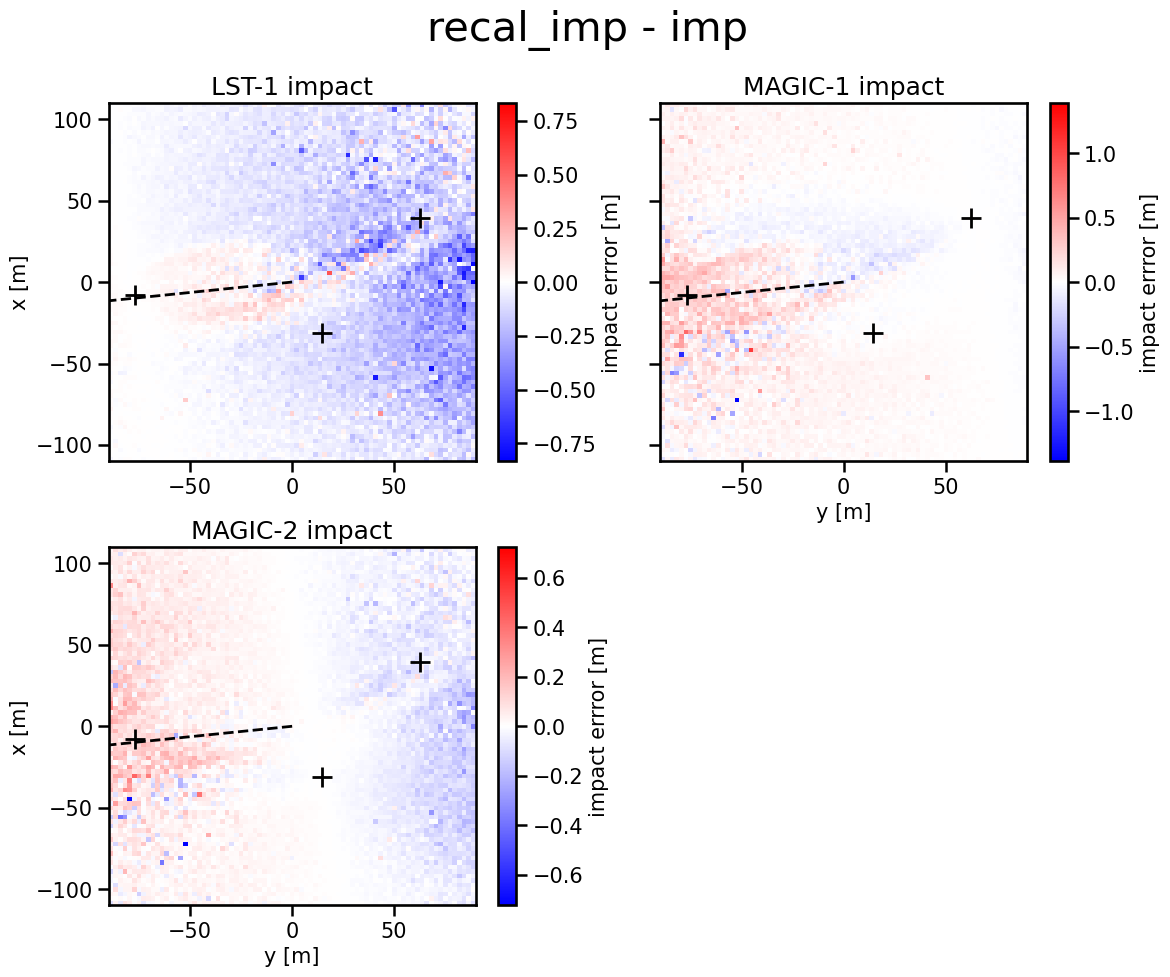

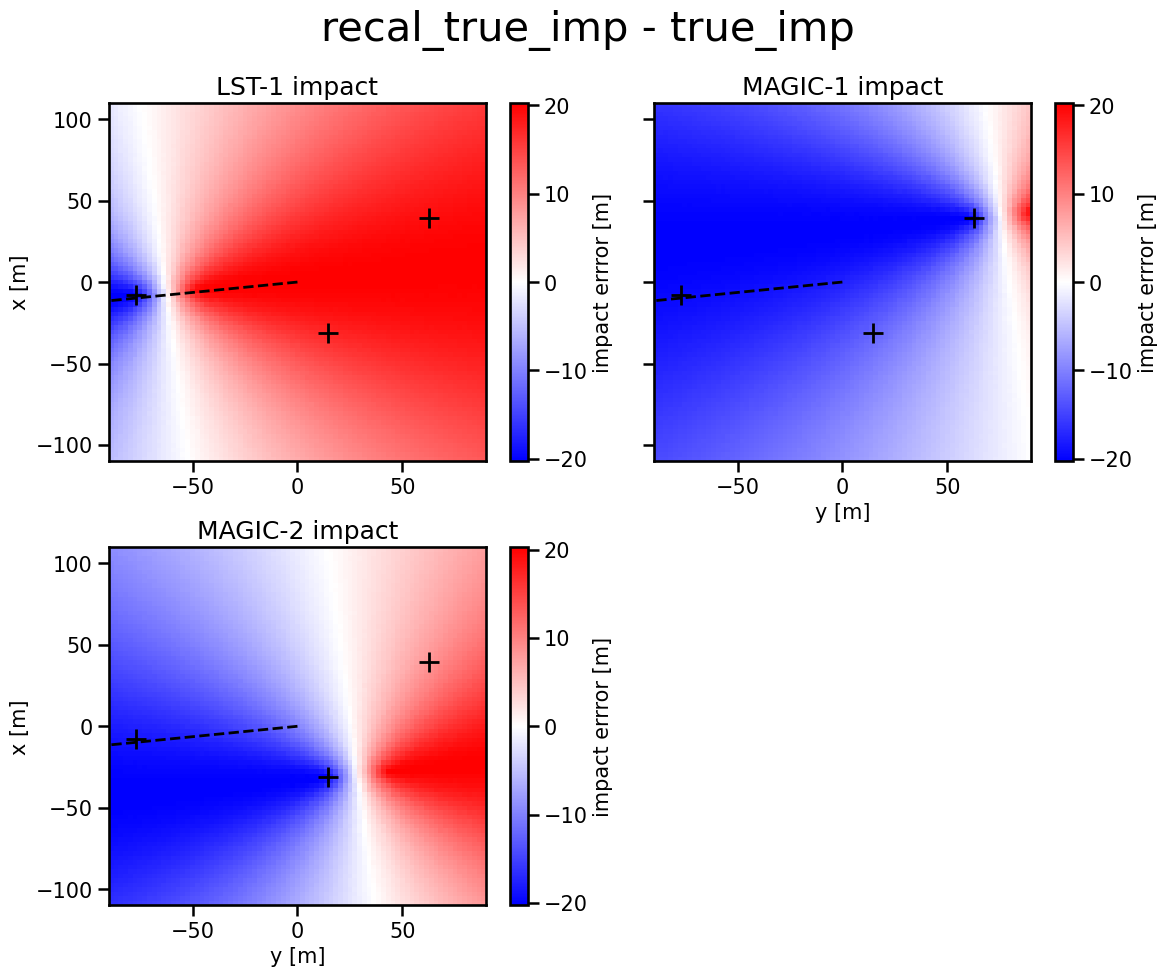

In [10]:
titles = ['true_imp - imp', 'recal_true_imp - recal_imp', 'recal_imp - imp', 'recal_true_imp - true_imp']

for title, data in zip(titles, [binned_A, binned_B, binned_C, binned_D]):

    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 10), sharey=True)
    fig.suptitle(title, fontsize=30)

    # plot the binned data
    for ax, i in zip([ax1, ax2, ax3], [0,1,2]):
        
        absmax = np.max([np.abs(np.nanmin(data[i])), np.nanmax(data[i])])
        
        cmesh = ax.pcolormesh(bins_x_center, bins_y_center, data[i], cmap='bwr', vmax=absmax, vmin=-absmax)
        fig.colorbar(cmesh, ax=ax, label='impact errror [m]')

    #######################################
    # --- plotting the direction line --- #
    #######################################
    for ax in [ax1, ax2, ax3]:
        ax.plot(*geom.line_in_direction(point_eq_angle, init_lower, ax), ls='--', lw=2, c='k')
    #######################################

    for ax, t in zip([ax1, ax2, ax3], ['LST-1 impact', 'MAGIC-1 impact', 'MAGIC-2 impact']):
        ax.set_title(t)
        ax.set_xlim(*xlim)
        ax.set_ylim(*ylim)
        ax.plot(xpos, ypos, ls='', c='k', marker='+', ms=15, lw=20)

    ax3.set_xlabel('y [m]')
    ax2.set_xlabel('y [m]')
    ax1.set_ylabel('x [m]')
    ax3.set_ylabel('x [m]')

    fig.delaxes(ax4)
    fig.tight_layout()
    plt.show()